In [1]:
import pandas as pd
from database import select_dataset
import numpy as np

In [2]:
# FIND WAY TO WRAP THIS CLEANLY CAUSE IT's A MESS !

aquastat = select_dataset('aquastat').dropna().drop(columns=['Area'])
aquastat = aquastat[~aquastat.ISO.isin(['USA', 'CHN', 'IND', 'RUS'])] # Not parsed !
aquastat = aquastat[aquastat.Variable != 'CI']
aquastat['Year'] = aquastat['Year'].astype(int)

evapotranspiration = select_dataset('evapotranspiration').dropna().drop_duplicates()
cropcalendar = select_dataset('cropcalendar').drop(columns=['Year'])
efficientwater = select_dataset('efficientwater')
wb_data = select_dataset('worldbank')
wb_data['Year'] = wb_data['Year'].astype(int)

MWU_df = pd.concat([aquastat, evapotranspiration, cropcalendar, efficientwater, wb_data])

In [3]:
from graphmodels.utils import df_to_data_dict

In [4]:
itemized = ['Kc', 'ICA']
data_dict = df_to_data_dict(MWU_df, itemized)
data_dict['LWU'] = 0

# Model

In [5]:
from graphmodels.graphmodel import GraphModel, converte_to_format, concatenate_graph_specs
import numpy as np
from graphmodels.validation import score_model, plot_diagnostic
from models.Sarah.model_EW import EW_models, MWU_model
from graphmodels.utils import get_X_y_from_data

In [6]:
model = EW_models['IWW_model']
X, y = get_X_y_from_data(model, data_dict)
res = model.run(X)

In [7]:
__author__ = 'Sarah'
__status__ = 'Pending Validation'

"""
TO DO.
"""
from graphmodels.graphmodel import GraphModel, concatenate_graph_specs
import numpy as np

# Conversions
height_rice = 0.2  # meter height of rice
ha_to_m2 = 1e4  # * 1e3
mm_to_m = 1  # 1e-3 TO CHECK
mmyear_to_m3year = 1  # from mm/year to m3/year as 1mm = 10m3/ha \n",

# Nodes
IWW_nodes = {'Kc': {'type': 'parameter', 'unit': '1', 'name': 'Crop Factor Vector'},
             'ICA': {'type': 'input', 'unit': '1000 ha', 'name': 'Irrigated crop Area'},
             'CI': {'type': 'variable',
                    'unit': '1',
                    'name': 'Cropping Intensity',
                    'computation': lambda ICA, AIR, **kwargs: ICA / AIR
                    },
             'ETo': {'type': 'input', 'unit': 'mm/year', 'name': 'Evapotranspiration'},
             'ETc': {'type': 'variable',
                     'name': 'Potential Crop Evaporation Vector',
                     'unit': 'mm/year',
                     'computation': lambda Kc, CI, ETo, **kwargs: (Kc * CI * ETo).groupby(level=['ISO', 'Year']).sum()
                     },
             'ETa': {'type': 'input',
                     'unit': 'mm/year',
                     'name': 'Actual Evapotranspiration'},
             'ICU': {'type': 'variable',
                     'name': 'Irrigation Consumptive Use',
                     'unit': 'mm/year',
                     'computation': lambda ETc, ETa, **kwargs: abs(ETc - ETa)  # bug to fix
                     },
             'AIR': {'type': 'parameter',
                     'unit': '1000 ha',
                     'name': 'Area Actually Irrigated'},
             'Arice': {'type': 'parameter',
                       'unit': '1000 ha',
                       'name': 'Area of Rice Paddy Irrigation'},
             'WRR': {'type': 'parameter', 'name': 'Water Requirement Ratio', 'unit': '1'},
             'IWR': {'type': 'variable',
                     'name': ' Irrigation Water Requirement',
                     'unit': 'm3/year',
                     'computation': lambda ICU, AIR, Arice, **kwargs: 1e-9 * ha_to_m2 * mmyear_to_m3year * ((ICU * AIR) + Arice * height_rice)
                     },
             'IWW': {'type': 'variable',
                     'name': ' Irrigation Water Withdrawal',
                     'unit': 'm3/year',
                     'computation': lambda IWR, WRR, **kwargs: IWR / WRR * 1e2
                     },
             'LWU': {'type': 'input', 'name': 'Livestock Water Use', 'unit': 'm3/year'},
             'AWU': {'type': 'variable', 'unit': 'm3/year',
                     'name': 'Agricultural Water Withdrawal',
                     'computation': lambda LWU, IWW, **kwargs: LWU + IWW
                     },
             }


def model_MWU(GDPC, WP, Pop):
    '''Find alternative to hard coding,
    also find way to link the regression data to those coefficient to improve reproducability
    '''

    return np.exp(-0.9522 - 0.3174 * np.log(WP) + 0.5918827 * np.log(GDPC) + 0.9859812 * np.log(Pop)) * 1e-9


MWU_nodes = {'WP': {'type': 'input', 'name': 'Water Price', 'unit': '$/15m3'},
             'GDPC': {'type': 'parameter', 'name': 'GDP per capita', 'unit': '$'},
             'Pop': {'type': 'parameter', 'name': 'Population', 'unit': 'capita'},
             'MWU': {'type': 'variable',
                     'name': 'Municipal Water Withdrawal',
                     'unit': 'm3/year',
                     'computation': lambda GDPC, WP, Pop, **kwargs: model_MWU(GDPC, WP, Pop)
                     }
             }


EW1_nodes = {'IWU': {'type': 'parameter',
                     'name': 'Industrial Water Withdrawal',
                     'unit': 'm3/year'},
             'AIR': {'type': 'parameter',
                     'unit': '1000 ha',
                     'name': 'Area Actually Irrigated'},
             'MWU': {'type': 'input',
                     'name': 'Municipal Water Withdrawal',
                     'unit': 'm3/year'},
             'AWU': {'type': 'input',
                     'name': 'Agricultural Water Withdrawal',
                     'unit': 'm3/year'},
             'TWW': {'type': 'variable',
                     'name': 'Total Water Withdrawal',
                     'unit': 'm3/year',
                     'computation': lambda AWU, IWU, MWU, **kwargs: AWU + IWU + MWU
                     },
              
             'AGVA': {'type': 'input',
                      'name': 'Agricultural Gross Value Added',
                      'unit': '$',
                     },
             
             'TC': {'type': 'parameter',
                    'unit': '1000 ha',
                    'name': 'Total Cultivated Land'},
             'PAIR': {'type': 'variable',
                    'name': 'Proportion of Irrigated Land',
                    'unit': '1',
                    'computation': lambda AIR, TC, **kwargs: AIR / TC
                    },
             'Cr': {'type': 'variable',
                    'name': 'Corrective coefficient',
                    'unit': '1',
                    'computation': lambda PAIR, **kwargs: 1 / (1 + (PAIR/(1-PAIR)*0.375))
                    },
             
             'IGVA': {'type': 'parameter',
                      'name': 'Industrial Gross Value Added',
                      'unit': '$'},
 
             'SGVA': {'type': 'parameter',
                      'name': 'Service Sector Gross Value Added',
                      'unit': '$'},
             'EW1': {'type': 'output',
                     'name': 'Water Use Efficiency',
                     'unit': '$/(m3/year)',
                     'computation': lambda TWW, AGVA, IGVA, SGVA, Cr, **kwargs: (AGVA * (1-Cr) + IGVA + SGVA)/(TWW * 1e9)
                     },
            }

EW2_nodes = {
    'IRWR': {'type': 'input',
                     'name': 'Internal Renewable Water Resources',
                     'unit': 'm3/year'},
    'ERWR': {'type': 'input',
             'unit': 'm3/year',
             'name': 'External Renewable Water Resources'},
    'TRF': {'type': 'variable',
            'name': 'Total Renewable Freshwater',
            'unit': 'm3/year',
            'computation': lambda IRWR, ERWR, **kwargs: IRWR + ERWR
            },
    'DW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Desalination Water'},
    'TW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Treated Wastewater'},
    'TNCW': {'type': 'variable',
             'name': 'Total Non Conventional Water',
             'unit': 'm3/year',
             'computation': lambda DW, TW, **kwargs: DW + TW
             },
    'TFA': {'type': 'variable',
            'name': 'Total Freshwater Available',
            'unit': 'm3/year',
            'computation': lambda TRF, TNCW, **kwargs: TRF + TNCW
            },
    'TWW': {'type': 'input', 'unit': 'm3/year', 'name': 'Total Water Withdrawal'},
    'EFR': {'type': 'parameter',
            'unit': 'm3/year',
            'name': 'Environmental Flow Requirement'},
    'EW2': {'type': 'output',
            'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
            'unit': '%',
            'computation': lambda TWW, TFA, EFR, **kwargs: TWW / (TFA - EFR) * 1e2
            },
    'Natural EW2': {'type': 'output',
                    'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
                    'unit': '%',
                    'computation': lambda TWW, TRF, EFR, **kwargs: TWW / (TRF - EFR) * 1e2
                    }
}
# models
IWW_model = GraphModel(IWW_nodes)
MWU_model = GraphModel(MWU_nodes)
EW1_partial_model = GraphModel(EW1_nodes)
EW2_partial_model = GraphModel(EW2_nodes)

EW1_model = GraphModel(concatenate_graph_specs([IWW_nodes, MWU_nodes, EW1_nodes]))
EW2_model = GraphModel(concatenate_graph_specs([IWW_nodes, MWU_nodes, EW2_nodes]))


# To check if it's usefull
EW_models = {'IWW_model': IWW_model,
             'EW1_partial_model': EW1_partial_model,
             'EW2_partial_model': EW2_partial_model,
             'EW1_model': EW1_model,
             'EW2_model': EW2_model
             }


In [8]:
for model_name, model in EW_models.items():
    print(model_name, ': ')
    X, y = get_X_y_from_data(model, data_dict)
    res = model.run(X)
    print(score_model(model, X, y))

IWW_model : 
         r2  correlation        rmse Variable
0  0.734552     0.859789   31.102888      IWR
1  0.036750     0.657641  285.155347      IWW
2  0.603102     0.821737  153.740444      AWU
EW1_partial_model : 
         r2  correlation         rmse Variable
0  0.987684     0.993828     4.519458      TWW
1  0.230513     0.576169  7560.506651      EW1
EW2_partial_model : 
         r2  correlation          rmse Variable
0  0.989336     0.995175   4272.565052      TFA
1 -0.404156     0.195124  57353.247805      EW2
EW1_model : 


/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


         r2  correlation         rmse Variable
0  0.734552     0.859789    31.102888      IWR
1  0.036750     0.657641   285.155347      IWW
2  0.603102     0.821737   153.740444      AWU
3  0.813129     0.904383     1.014062      MWU
4  0.708943     0.862557   168.975281      TWW
5 -1.071986     0.406579  5172.641189      EW1
EW2_model : 


/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


         r2  correlation          rmse Variable
0  0.734552     0.859789     31.102888      IWR
1  0.036750     0.657641    285.155347      IWW
2  0.603102     0.821737    153.740444      AWU
3  0.813129     0.904383      1.014062      MWU
4  0.989336     0.995175   4272.565052      TFA
5 -0.404156     0.195124  57353.247805      EW2


In [14]:
X, y = get_X_y_from_data(EW1_model, data_dict)


plot_diagnostic(EW1_model, X, y, 'EW1', hover_data=['ISO'])

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning:

divide by zero encountered in log



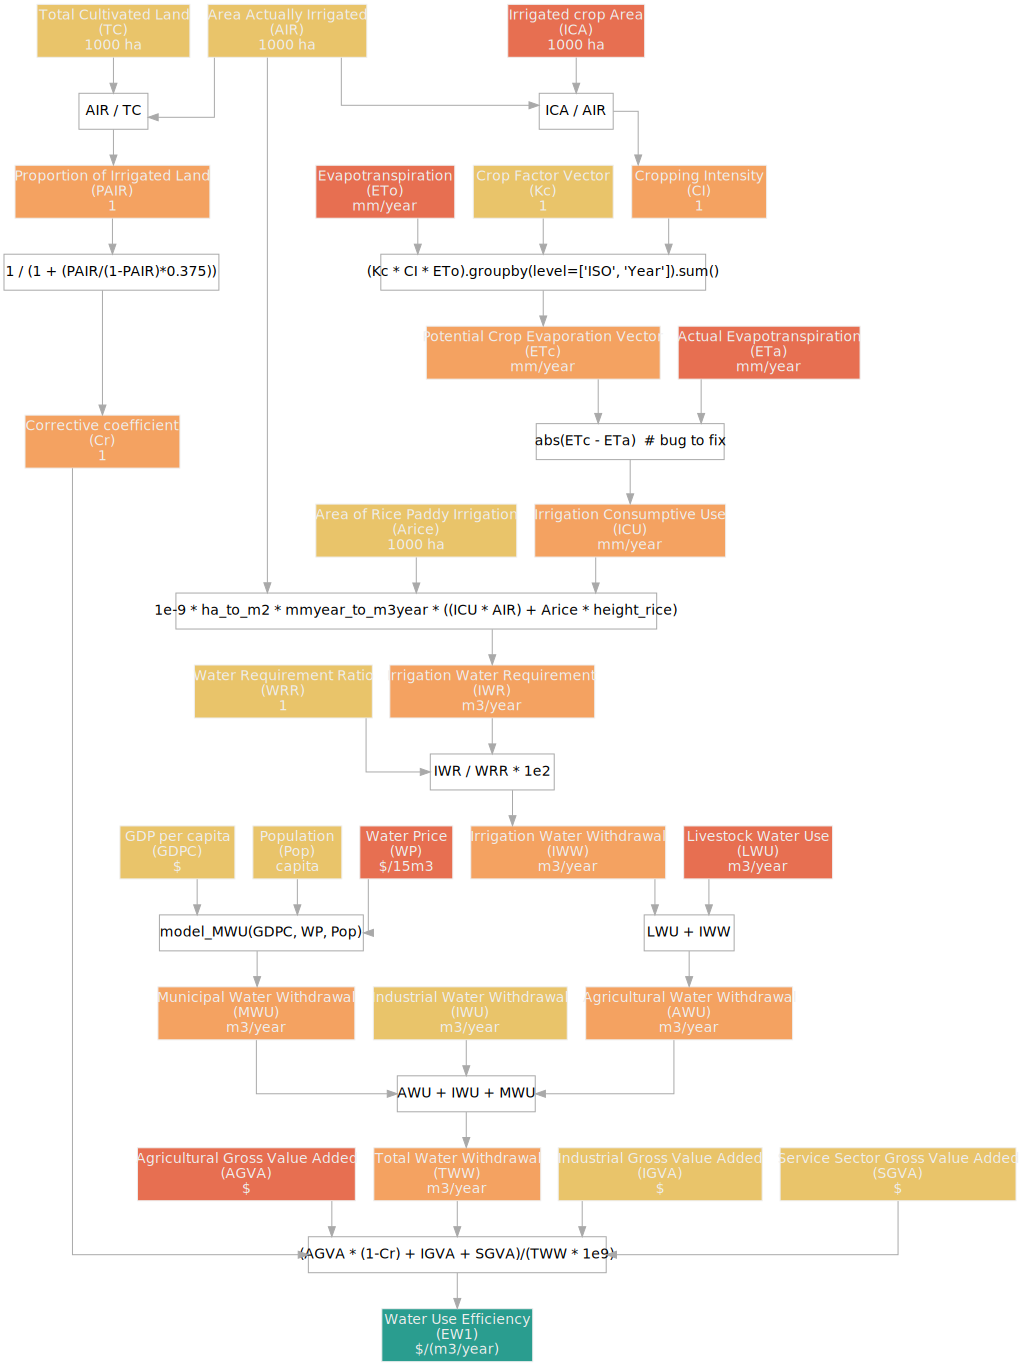

In [9]:
X, y = get_X_y_from_data(EW1_model, data_dict)


plot_diagnostic(EW1_model, X, y, 'EW1', hover_data=['ISO'])

In [15]:
sm.EW_models['']

{'IWW_model': <graphmodels.graphmodel.GraphModel at 0x7fbcfaa25250>,
 'EW1_partial_model': <graphmodels.graphmodel.GraphModel at 0x7fbcfaa252d0>,
 'EW2_partial_model': <graphmodels.graphmodel.GraphModel at 0x7fbcfaa25bd0>,
 'EW1_model': <graphmodels.graphmodel.GraphModel at 0x7fbcfa9b49d0>,
 'EW2_model': <graphmodels.graphmodel.GraphModel at 0x7fbcfaf75790>}

In [12]:
import models.Sarah.model_EW as sm

for model_name, model in sm.EW_models.items():
    print(model_name, ': ')
    X, y = get_X_y_from_data(model, data_dict)
    res = model.run(X)
    print(score_model(model, X, y))

IWW_model : 
         r2  correlation        rmse Variable
0  0.734552     0.859789   31.102888      IWR
1  0.036750     0.657641  285.155347      IWW
2  0.603102     0.821737  153.740444      AWU
EW1_partial_model : 
         r2  correlation          rmse Variable
0  0.987684     0.993828      4.519458      TWW
1 -0.279845     0.443659  12512.483489      EW1
EW2_partial_model : 
         r2  correlation          rmse Variable
0  0.989336     0.995175   4272.565052      TFA
1 -0.404156     0.195124  57353.247805      EW2
EW1_model : 


/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


         r2  correlation         rmse Variable
0  0.734552     0.859789    31.102888      IWR
1  0.036750     0.657641   285.155347      IWW
2  0.603102     0.821737   153.740444      AWU
3  0.813129     0.904383     1.014062      MWU
4  0.708943     0.862557   168.975281      TWW
5 -1.091887     0.405643  5222.323376      EW1
EW2_model : 


/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


         r2  correlation          rmse Variable
0  0.734552     0.859789     31.102888      IWR
1  0.036750     0.657641    285.155347      IWW
2  0.603102     0.821737    153.740444      AWU
3  0.813129     0.904383      1.014062      MWU
4  0.989336     0.995175   4272.565052      TFA
5 -0.404156     0.195124  57353.247805      EW2
